# Histopathologic Cancer Detection Using CNN

In this compettition we must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates).



Lets first import some packages and download the dataset

In [4]:
! pip install -q kaggle

In [5]:
!pip install tensorflow
!pip install keras

In [8]:
from glob import glob
import numpy as np
import pandas as pd
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization, RandomFlip, RandomZoom, RandomRotation, Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

#from tqdm import tqdm_notebook,trange
print("done import")

done import


In [9]:
from google.colab import files

files.upload()

dataset = 'histopathologic-cancer-detection'

!rm -r $dataset

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c $dataset

zip_file = f"{dataset}.zip"
destination_dir = f"/content/{dataset}"

if not os.path.exists(zip_file):
    print(f"Error: {zip_file} not found.")
else:
    !unzip -q $zip_file -d $destination_dir
    !rm $zip_file

Saving kaggle.json to kaggle.json
rm: cannot remove 'histopathologic-cancer-detection': No such file or directory
rm: cannot remove '/root/.kaggle': No such file or directory
100% 6.31G/6.31G [04:27<00:00, 32.4MB/s]
100% 6.31G/6.31G [04:27<00:00, 25.3MB/s]


In [11]:
path = './histopathologic-cancer-detection/'
train_path = './histopathologic-cancer-detection/train/'
test_path = './histopathologic-cancer-detection/test/'

## EDA and Data Cleaning

Lets look at the training data frame

In [12]:
all_train_df = pd.read_csv(path+"train_labels.csv")
all_train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


We see that each row has an ID which is a image file name in the training data set and labael which is a binary value 0 or 1 depednign on wether the image represents a tumor or not.

Lets see how mant training and test data samples we have.

In [13]:
print("Train Size: {}".format(len(os.listdir(train_path))))
print("Test Size: {}".format(len(os.listdir(test_path))))

Train Size: 220025
Test Size: 57458


Fairly large dataset.
Lets set the distribution of the two labels in the trainign set

label
0    130908
1     89117
Name: count, dtype: int64


(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

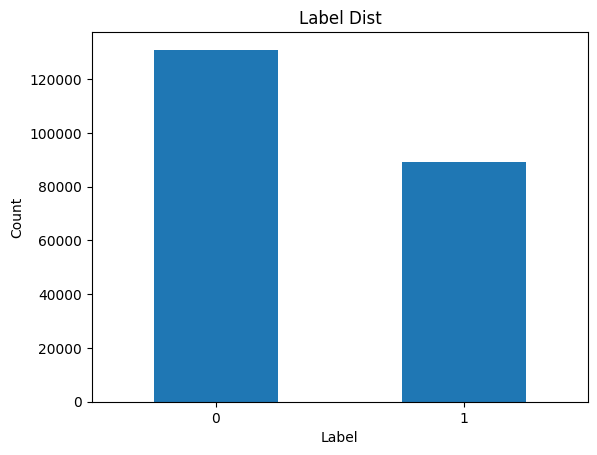

In [14]:
label_counts = all_train_df.label.value_counts()
print(label_counts)


# histogram
plt.figure()
ax = label_counts.plot(kind='bar')
plt.title('Label Dist')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)

In [15]:
all_train_df["id"] = all_train_df["id"].apply(lambda x: x + ".tif")
all_train_df["label"] = all_train_df["label"].astype(str)

Lets look at some of these images and their corresponding labels.

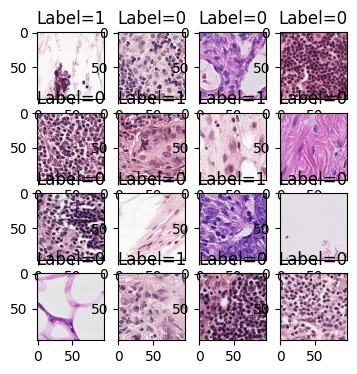

In [18]:
N_plot=4
fig = plt.figure(figsize=(N_plot, N_plot))

for i in range(1,N_plot**2+1):
        img=Image.open(train_path+all_train_df['id'][i])
        fig.add_subplot(N_plot, N_plot, i)
        plt.imshow(img)
        plt.title('Label=%s'%all_train_df['label'][i])




Now lets create data generators for the training and vaildation sets. We will first scale the data so that all the values are between 0 and 1 insead of 0 to 255

In [19]:
data_generator = ImageDataGenerator(rescale=1./255.,
                            validation_split=0.2)

In [20]:
train_data_generator = data_generator.flow_from_dataframe(
    dataframe=all_train_df,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=256,
    seed=5,
    class_mode="binary",
    target_size=(64,64),
    shuffle=True)

Found 176020 validated image filenames belonging to 2 classes.


In [21]:
val_data_generator = data_generator.flow_from_dataframe(
    dataframe=all_train_df,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=256,
    seed=5,
    class_mode="binary",
    target_size=(64,64),
    shuffle=True)

Found 44005 validated image filenames belonging to 2 classes.


## Model Architecture

As instructed we will use a CNN model. We will also use some of the recommended techinques to prevent over fitting such as batch normalization

In [25]:


model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(filters=16, kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))

model.add(Conv2D(filters=32, kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(filters=32, kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(1, activation = "sigmoid"))

model.build(input_shape=(32, 64, 64, 3))

model.compile(Adam(0.001), loss = "binary_crossentropy", metrics=['accuracy'])


# model.summary()


Lets plot the model architecture for review

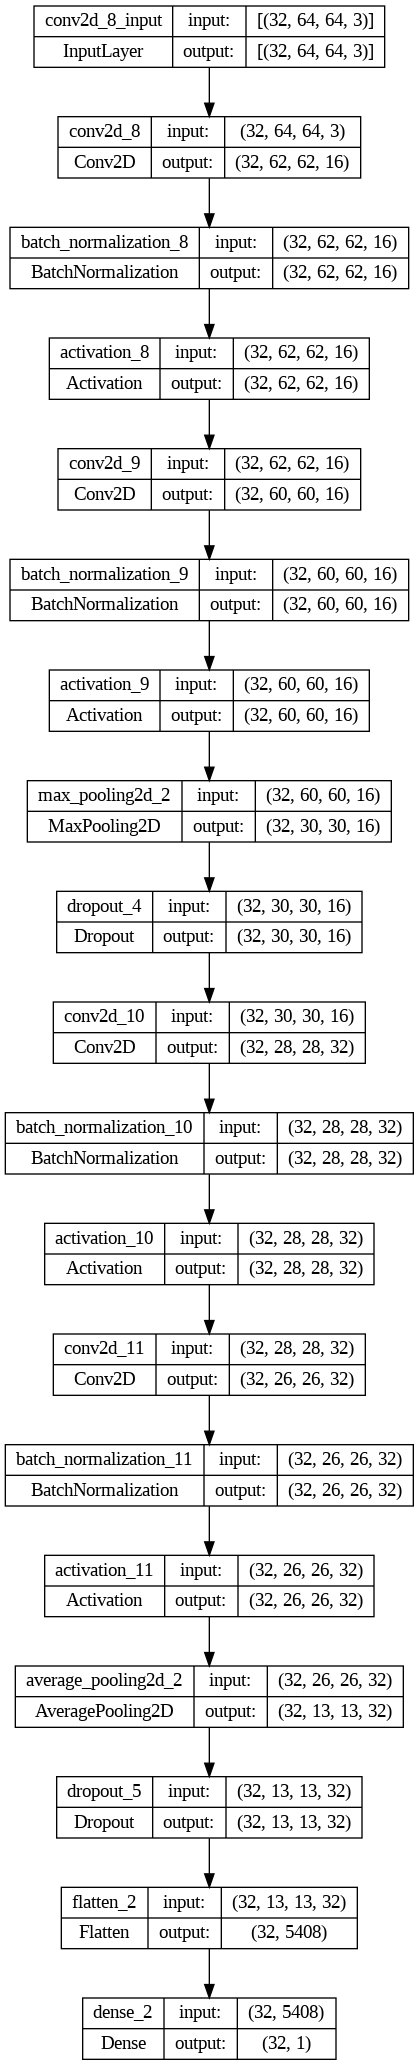

In [24]:

from keras.utils import plot_model

 plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Lets look at the number of parameters in the model

In [26]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (32, 62, 62, 16)          448       
                                                                 
 batch_normalization_12 (Ba  (32, 62, 62, 16)          64        
 tchNormalization)                                               
                                                                 
 activation_12 (Activation)  (32, 62, 62, 16)          0         
                                                                 
 conv2d_13 (Conv2D)          (32, 60, 60, 16)          2320      
                                                                 
 batch_normalization_13 (Ba  (32, 60, 60, 16)          64        
 tchNormalization)                                               
                                                                 
 activation_13 (Activation)  (32, 60, 60, 16)         

We wil now try a run of 5 training epochs with Adam learning rate 0.001 we defined before

In [ ]:
detection_cnn = model.fit(
                        train_data_generator,
                        steps_per_epoch=650,
                        epochs=5,
                        validation_data=val_data_generator,
                        validation_steps=170,
                        verbose=1)

Epoch 1/5
650/650 [==============================] - 148s 223ms/step - loss: 0.3909 - accuracy: 0.8306 - val_loss: 0.3826 - val_accuracy: 0.8338
Epoch 2/5
650/650 [==============================] - 149s 230ms/step - loss: 0.3279 - accuracy: 0.8617 - val_loss: 0.3520 - val_accuracy: 0.8501
Epoch 3/5
650/650 [==============================] - 148s 228ms/step - loss: 0.2954 - accuracy: 0.8777 - val_loss: 0.3543 - val_accuracy: 0.8445
Epoch 4/5
650/650 [==============================] - 144s 221ms/step - loss: 0.2786 - accuracy: 0.8848 - val_loss: 1.6023 - val_accuracy: 0.6515
Epoch 5/5
650/650 [==============================] - 149s 229ms/step - loss: 0.2648 - accuracy: 0.8919 - val_loss: 0.8504 - val_accuracy: 0.7793


We see that while trainign acccuracy keeps increasing the validation accuracy starts droping after epoch 3 indicating overfitting

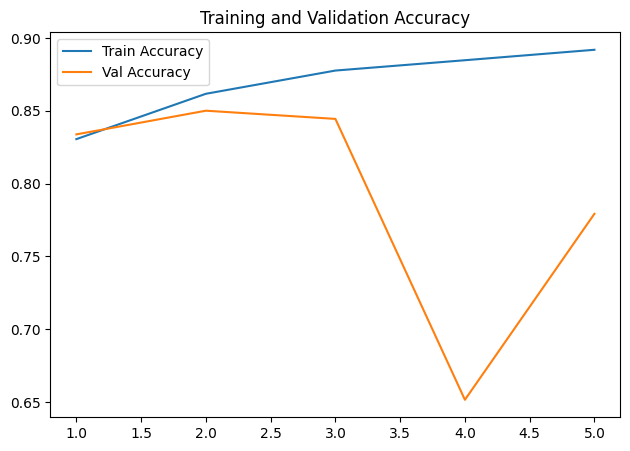

In [ ]:
model_acc = detection_cnn.history['accuracy']
val_model_acc = detection_cnn.history['val_accuracy']

epochs = range(1,len(model_acc)+1)

# accuracy
plt.figure(figsize=(25, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs, model_acc, label='Train Accuracy')
plt.plot(epochs, val_model_acc, label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

In [ ]:
print(epochs)

range(0, 5)


Lets re-compile with smaller number of epochs (3) and slower learning rate 0.0001

In [ ]:
model.compile(Adam(0.0001), loss = "binary_crossentropy", metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, None, None, 16)    448       
                                                                 
 batch_normalization_20 (Ba  (None, None, None, 16)    64        
 tchNormalization)                                               
                                                                 
 activation_12 (Activation)  (None, None, None, 16)    0         
                                                                 
 conv2d_23 (Conv2D)          (None, None, None, 16)    2320      
                                                                 
 batch_normalization_21 (Ba  (None, None, None, 16)    64        
 tchNormalization)                                               
                                                                 
 activation_13 (Activation)  (None, None, None, 16)   

In [ ]:
detection_cnn = model.fit(
                        train_data_generator,
                        steps_per_epoch=650,
                        epochs=3,
                        validation_data=val_data_generator,
                        validation_steps=170,
                        verbose=1)

Epoch 1/3
650/650 [==============================] - 148s 223ms/step - loss: 0.2369 - accuracy: 0.9048 - val_loss: 0.2827 - val_accuracy: 0.8871
Epoch 2/3
650/650 [==============================] - 145s 223ms/step - loss: 0.2328 - accuracy: 0.9065 - val_loss: 0.2677 - val_accuracy: 0.8921
Epoch 3/3
650/650 [==============================] - 144s 221ms/step - loss: 0.2288 - accuracy: 0.9080 - val_loss: 0.3204 - val_accuracy: 0.8790


We now see better validation accuracy and we se ephoch 3 is just about the righ time to stop trinaing before overfitting starts to havce significant determinental impact

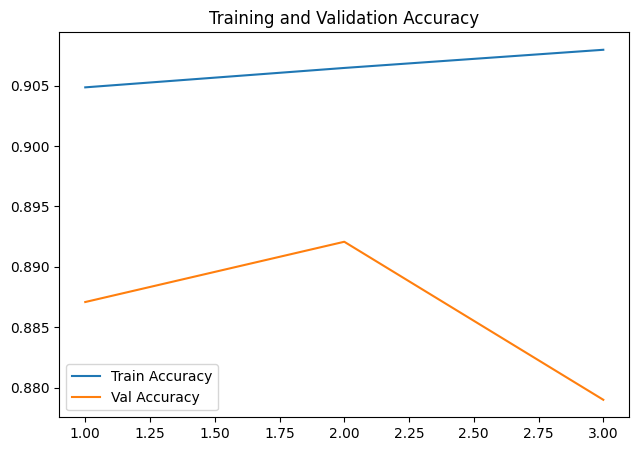

In [ ]:
model_acc = detection_cnn.history['accuracy']
val_model_acc = detection_cnn.history['val_accuracy']

epochs = range(1,len(model_acc)+1)

# accuracy
plt.figure(figsize=(25, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs, model_acc, label='Train Accuracy')
plt.plot(epochs, val_model_acc, label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

## Predict on Test Data and Create Submission File

In [ ]:
test_df = pd.DataFrame({'id':os.listdir(test_path)})
test_df.head()

,id
0,e26a607c4b490b67a979d4f70a1b1939e068b5c3.tif
1,de9f8e5becbf0b2c2c6a6e707ba1ed5ef6df7ef3.tif
2,0c72b29dc06df71e5c63d6b3b3e9e1c807a560fa.tif
3,0a49770a30d2761103e69d2a9e70299c08a0a9a8.tif
4,a11eb4dc98c26b71e397b0a1c26cf3d1181bda74.tif


In [ ]:
data_generator_test = ImageDataGenerator(rescale=1./255.)

test_data_generator = data_generator_test.flow_from_dataframe(
    dataframe=test_df,
    directory=test_path,
    x_col='id',
    y_col=None,
    target_size=(64,64),
    batch_size=1,
    shuffle=False,
    class_mode=None)

Found 57458 validated image filenames.


In [ ]:
results = model.predict(test_data_generator, verbose=1)

57458/57458 [==============================] - 140s 2ms/step


In [ ]:
results = np.transpose(results)[0]
submission_df = pd.DataFrame()
submission_df['id'] = test_df['id'].apply(lambda x: x.split('.')[0])
submission_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, results))
submission_df.head()

,id,label
0,e26a607c4b490b67a979d4f70a1b1939e068b5c3,0
1,de9f8e5becbf0b2c2c6a6e707ba1ed5ef6df7ef3,0
2,0c72b29dc06df71e5c63d6b3b3e9e1c807a560fa,0
3,0a49770a30d2761103e69d2a9e70299c08a0a9a8,0
4,a11eb4dc98c26b71e397b0a1c26cf3d1181bda74,0


In [ ]:
submission_df.to_csv('submission.csv', index=False)

In [ ]:
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Conclusion

The Deep CNN model with batch normalization and dropout layers was effctive to reach close to 90% validation accuracy.
We saw that slower learning rate of 0.0001 gave better results.
Also we had to stop training early enough (epoch 3 to avoid overfitting)
